In [2]:
# import logging
# logging.captureWarnings(True)
# logging.getLogger('py.warnings').setLevel(logging.ERROR)

import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from scipy import stats
import scipy
from scipy.interpolate import make_interp_spline, BSpline
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
# import wrf

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

%matplotlib inline
from IPython.display import Image, display

Get IVT and IWV values for SB during March AR Event

In [3]:
## Latitude and longitude of Santa Barbara
SB_lat = 34.5
SB_lon = -119.5+360

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=SB_lat, longitude=SB_lon)

filename_pattern =  '../data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4',
                       preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

da_SPFH = ds.spfh.sel(p=slice(1000,300))
da_V = ds.v.sel(p=slice(1000,300))
da_U = ds.u.sel(p=slice(1000,300))
pressure = ds.p.sel(p=slice(1000,300)).values

zero_isotherm = ds.hgt_0Cisotherm.sel(time=slice('2019-03-06-12', '2019-03-06-18'))
zeroiso_event = np.mean(zero_isotherm.values)

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  # Remove the CWD from sys.path while we load stuff.
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


ds size in GB 0.00



In [4]:
### Calculate IVT and IWV
g = -9.81 # gravity constant
pressure = pressure*100 # convert from hPa to Pa
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=1)/g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=1)/g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

iwv = scipy.integrate.trapz(da_SPFH, pressure, axis=1)/g

(12,)
(12,)


In [7]:
ivt_total[3:]

array([ 21.638157,  25.703451,  78.53529 , 232.88206 , 367.32388 ,
       336.2036  , 446.16397 , 411.46542 , 177.95615 ], dtype=float32)

Get IVT Characteristics (Mean IVT, IVT Direction) for SB AR Events

In [4]:
latitude=34.5
longitude=359.375-119.375

filename =  '../data/ar_catalog/globalARcatalog_MERRA2_1980-2019_v3.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()

ds_SB = ds.sel(lat=latitude, lon=longitude)
ds_SB = ds_SB.squeeze()
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

ds size in GB 290.43

xarray.Dataset {
dimensions:
	lat = 361 ;
	limitID = 5 ;
	lon = 576 ;
	stageID = 9 ;
	time = 57584 ;

variables:
	float32 shape(time, lat, lon) ;
		shape:long_name = Shape ;
		shape:units = none ;
	float64 axis(time, lat, lon) ;
		axis:long_name = Axis ;
		axis:units = none ;
	float64 tnsct(time, lat, lon) ;
		tnsct:long_name = Transect ;
		tnsct:units = none ;
	float32 lfloc(time, lat, lon) ;
		lfloc:long_name = Landfall Location ;
		lfloc:units = none ;
	float32 islnd(lat, lon) ;
		islnd:long_name = Is Land (Major Landmasses Only) ;
	float32 iscst(lat, lon) ;
		iscst:long_name = Is Coast (Major Landmasses Only; Inland Water Bodies Not Considered) ;
	float64 lon(lon) ;
		lon:units = degrees_east ;
	float64 lat(lat) ;
		lat:units = degrees_north ;
	float64 lev() ;
		lev:units = m ;
	datetime64[ns] time(time) ;
		time:ntime_written = 56980.0 ;
	float64 ens() ;
		ens:axis = e ;
	float32 year(time, lon) ;
		year:long_name = Year ;
		year:units = none ;
	float32 month

In [5]:
def get_ivt_characteristics(ds1, ds2):
    da = ds1.shape.dropna(dim='time') ## drop the times where there is no AR present
    idx_times = np.unique(da['time']) ## list of days where AR is present in loc
    times_list = pd.DatetimeIndex(idx_times) ## create a pandas datetime index for easy time use
    ds_new = ds2.sel(time=times_list) # get only AR days

    ## get the ivt magnitude of the AR object that is over SB
    ivtx = []
    ivty = []
    ivtdir = []
    idx_shape = da.values.astype(int) # get integer index values of ar object
    for i in range(len(times_list)):
        ivtx.append(ds_new.ivtx[i].isel(lon=idx_shape[i]).values)
        ivty.append(ds_new.ivty[i].isel(lon=idx_shape[i]).values)
        ivtdir.append(ds_new.ivtdir[i].isel(lon=idx_shape[i]).values)
    ivtx = np.asarray(ivtx)
    ivty = np.asarray(ivty)
    ivtmag = np.sqrt(ivtx**2 + ivty**2)
    ivtdir = np.asarray(ivtdir)
    
    return(ivtmag, ivtdir)

In [6]:
## get ivt characteristics for all AR events in SB
ivtmag, ivtdir = get_ivt_characteristics(ds_SB, ds)
print(ivtdir.shape)

## get ivt direction for AR events in march only
def is_mar(month):
    return (month == 3)

ds_march = ds_SB.sel(time=is_mar(ds['time.month']))
ivtmag_march, ivtdir_march = get_ivt_characteristics(ds_march, ds)
print(ivtdir_march.shape)

(3779,)
(384,)


In [7]:
## Get characteristics of specific AR event
ds_event = ds.sel(time='2019-03-05 12:00')
da = ds_SB.shape.dropna(dim='time') ## drop the times where there is no AR present
idx_event = da.sel(time= '2019-03-05 12:00')
ivtdir_event = ds_event.ivtdir.isel(lon=idx_event.astype(int))
print('IVT Direction during March AR Event:', ivtdir_event.values)

ivtx_event = ds_event.ivtx.isel(lon=idx_event.astype(int))
ivty_event = ds_event.ivty.isel(lon=idx_event.astype(int))
ivtmag_event = np.sqrt(ivtx_event**2 + ivty_event**2)
print('IVT Magnitude during March AR Event:', ivtmag_event.values)

IVT Direction during March AR Event: 56.51005
IVT Magnitude during March AR Event: 382.1346


Get 0C Isotherm Values for SB AR Events

In [10]:
filename = '../data/MERRA-2/SB_AR_0_degree_isotherm.nc'
ds = xr.open_dataset(filename)

ht = ds.H
t = ds.T - 273.15 # convert to Kelvin

interp_results = wrf.interplevel(ht, t, 0.0, missing=np.nan)

## select SB
latitude=34.5
longitude=-119.375

SB_results = interp_results.sel(lat=latitude, lon=longitude)

## select only March events
def is_mar(month):
    return (month == 3)

ds_march = interp_results.sel(time=is_mar(interp_results['time.month']), lat=latitude, lon=longitude)
# ds_march

<xarray.DataArray 'H_interp' (time: 170)>
array([2626.2974, 2242.571 , 1901.8168, 3068.9912, 1801.7705, 1963.5237,
       2256.1301, 3279.135 , 3632.4856, 3127.7463, 3305.712 , 3177.5159,
       2261.1553, 1558.5488, 2474.6123, 1409.7407, 2186.1562, 2456.855 ,
             nan, 1966.726 , 2557.8716, 3017.712 , 3332.0159, 3466.5903,
       1991.9781, 2266.4978, 2634.7563, 3478.7983, 3916.1326, 3326.6904,
       3445.818 , 2698.1594, 4025.9702, 4191.3833, 2887.9407, 2146.6245,
       1493.9425, 3568.44  , 3297.325 , 2226.287 , 3756.794 , 3287.252 ,
       2571.888 , 2987.4297, 2202.794 , 4169.0015, 3031.9534, 3332.4927,
       3886.8108, 4055.182 , 3676.201 , 3461.4758, 3906.9421, 3713.2336,
       3688.1768, 3720.3264, 3173.163 , 3586.2158, 3974.251 , 2867.6494,
       3853.3103, 3376.1506, 3351.0366, 2331.7085, 3493.985 , 2155.6086,
       1972.2051, 2964.162 , 3421.438 , 3192.9841, 1800.5305, 1500.7511,
       1938.0951, 1668.3403, 1650.2305, 2139.5215, 2822.3267, 2384.6125,
       20

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


./figures/fS3.png


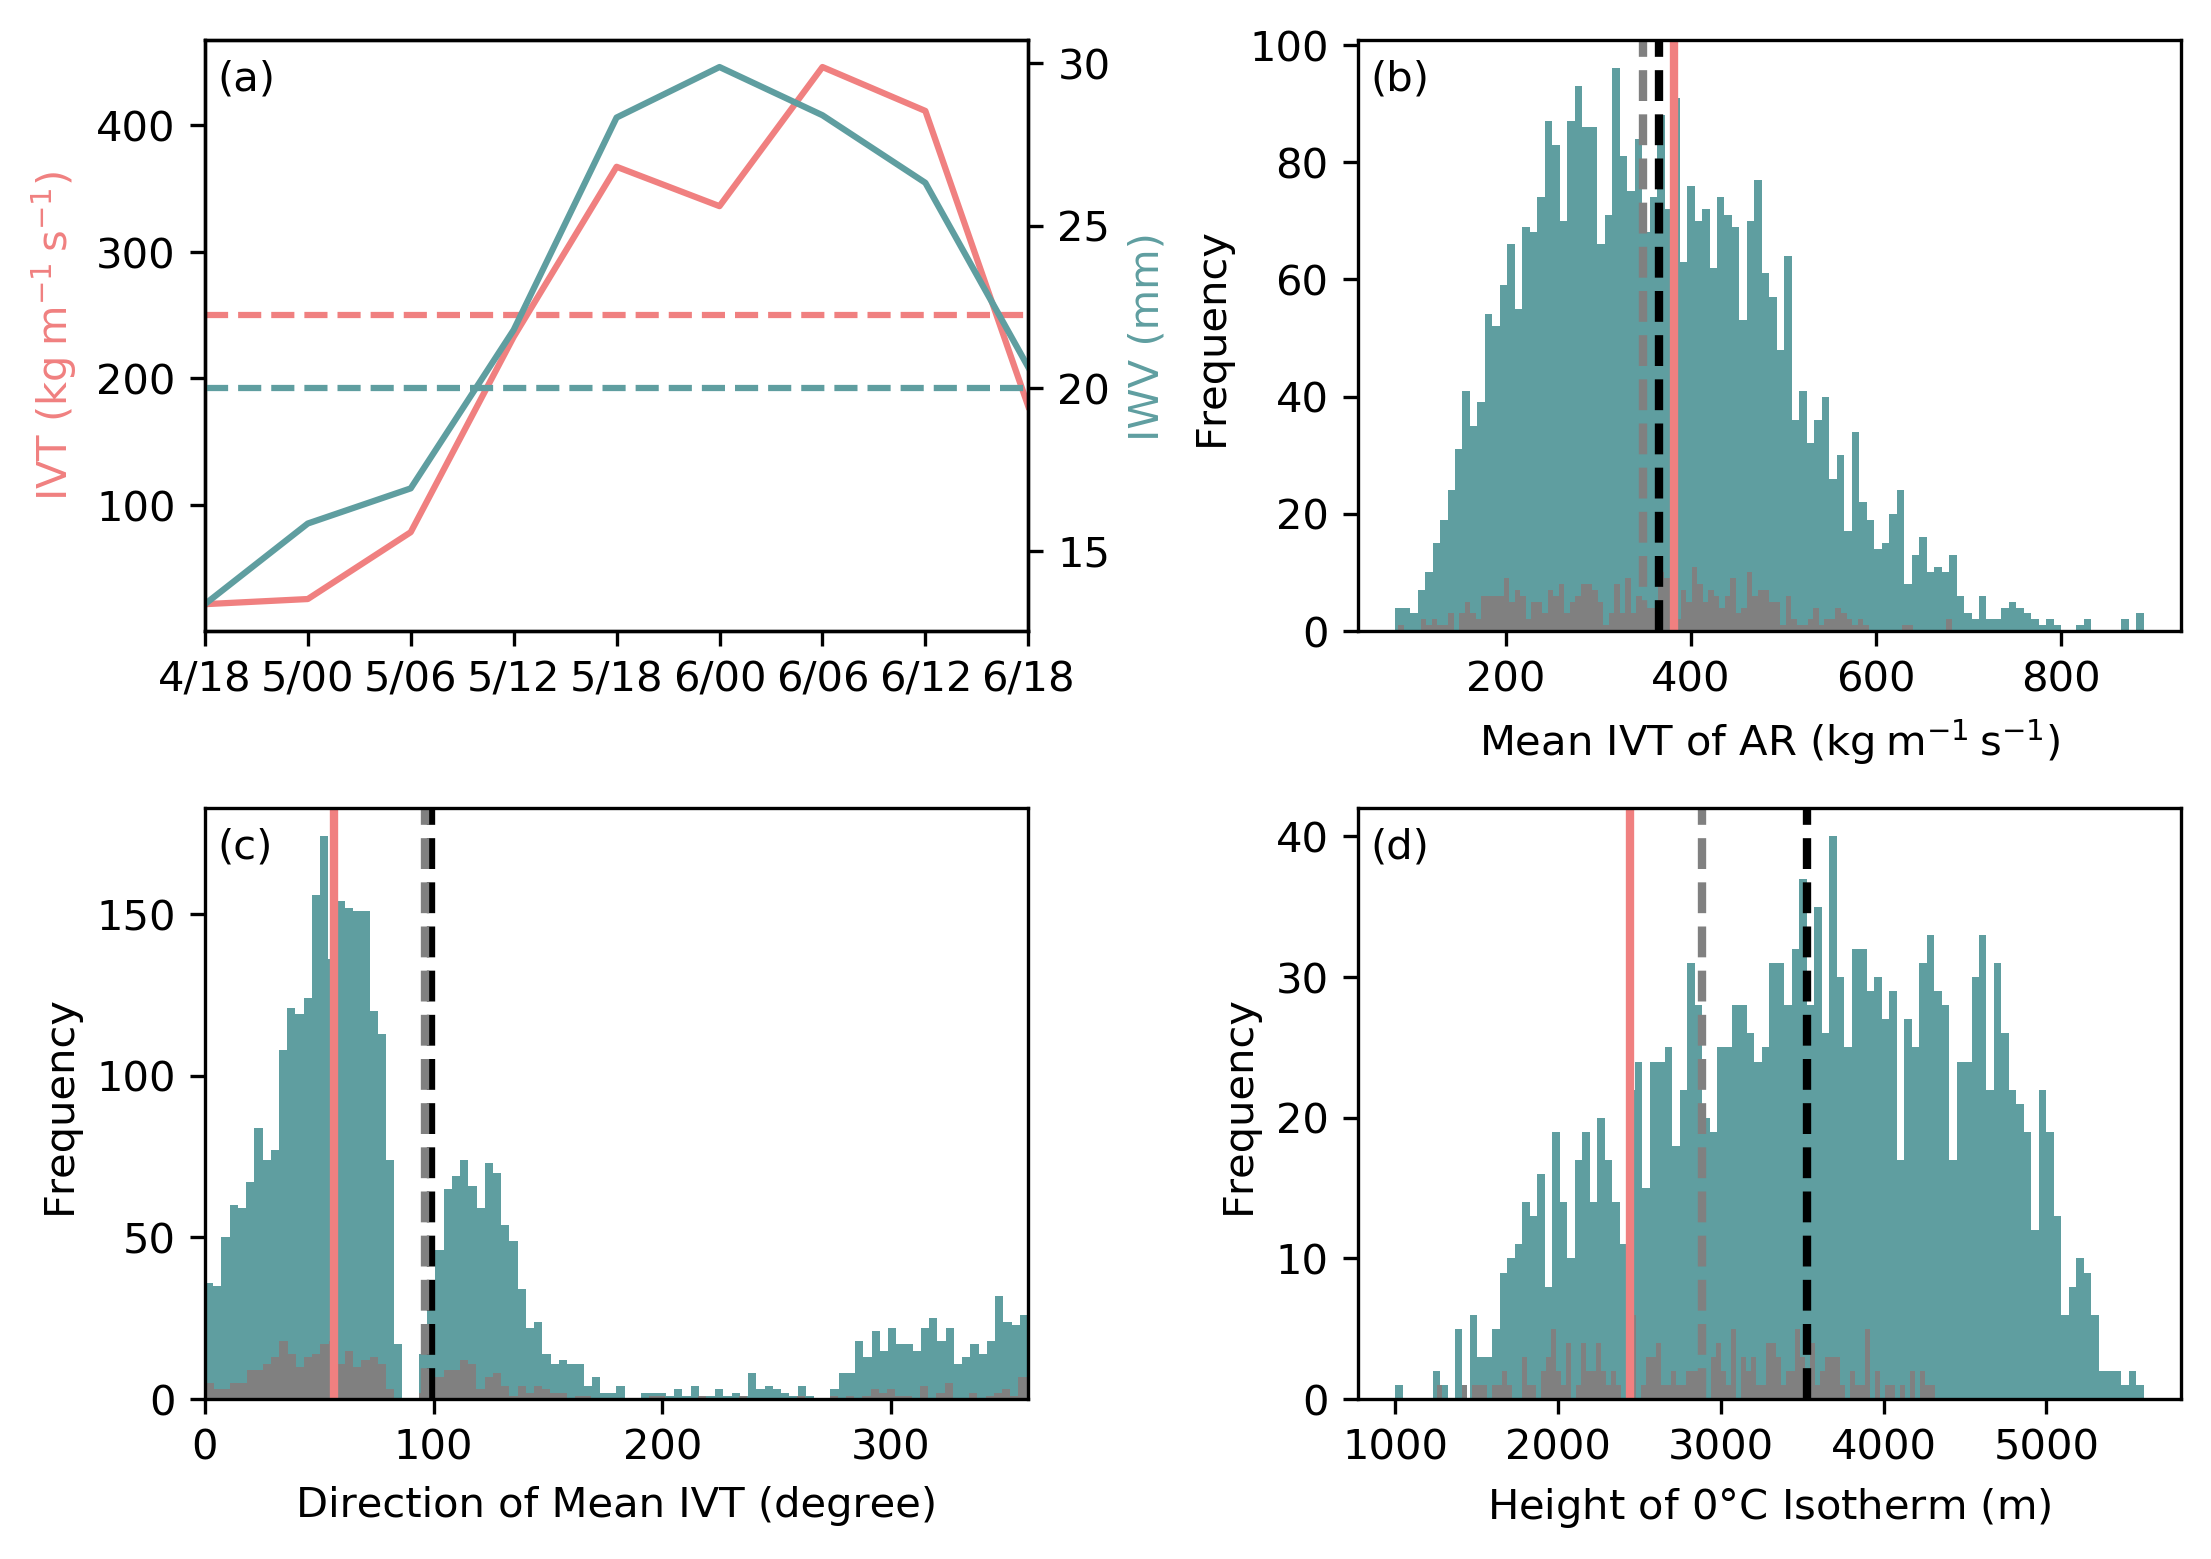

<Figure size 2550x1800 with 0 Axes>

In [23]:
fig = plt.figure(1, figsize=(8.5, 6))
fig.dpi = 300
fname = './figures/fS3'
fmt1 = 'png'
fmt2 = 'pdf'

numrows = 2
numcols = 2
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = gridspec.GridSpec(numrows, numcols, hspace=0.3, wspace=0.4)
red = 'lightcoral'
blue = 'cadetblue'
########################################################
# Plot for Figure S3a - IWV and IVT for March AR Event #
########################################################
ax1 = plt.subplot(gs[0, 0])
ax1.plot(ivt_total[3:], color=red)
ax1.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=10., color=red)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim(0,8)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(iwv[3:], color=blue)
ax2.set_ylabel('IWV (mm)', fontsize=10., color=blue)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_xlim(0,8)

# horizontal line indicating the threshold
ax1.axhline(y=250.0, color=red, linestyle='--')
ax2.axhline(y=20.0, color=blue, linestyle='--')

xticklabels = ['4/18', '5/00', '5/06', '5/12', '5/18',
            '6/00', '6/06', '6/12', '6/18']
# locs, labels = xticks()            # Get locations and labels
plt.xticks(np.arange(9), xticklabels)  # Set locations and labels
plt.xlabel('day/time (UTC)')
ax1.annotate('(a)', (3, 130), xycoords='axes points', fontsize=10.)

#################################################
# Plot for Figure S3b - IVT Magnitude Histogram #
#################################################
ax3 = plt.subplot(gs[0, 1])
n_bins = 100
ax3.hist(ivtmag, bins=n_bins, facecolor=blue)
ax3.axvline(np.nanmean(ivtmag), color='k', linestyle='--', linewidth=2)
ax3.hist(ivtmag_march, bins=n_bins, facecolor='grey')
ax3.axvline(np.nanmean(ivtmag_march), color='grey', linestyle='--', linewidth=2)
ax3.axvline(ivtmag_event.values, color=red, linestyle='-', linewidth=2)
# ax3.set_xlim(0, 360)
ax3.set_xlabel('Mean IVT of AR ($\mathrm{kg \: m^{-1} \: s^{-1}}$)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
# ax3.title.set_text('Mean IVT for ARs in Santa Barbara')
ax3.annotate('(b)', (3, 130), xycoords='axes points', fontsize=10.)


#################################################
# Plot for Figure S3c - IVT Direction Histogram #
#################################################
ax4 = plt.subplot(gs[1, 0])
n_bins = 100
ax4.hist(ivtdir, bins=n_bins, facecolor=blue)
ax4.axvline(np.nanmean(ivtdir), color='k', linestyle='--', linewidth=2)
ax4.hist(ivtdir_march, bins=n_bins, facecolor='grey')
ax4.axvline(np.nanmean(ivtdir_march), color='grey', linestyle='--', linewidth=2)
ax4.axvline(ivtdir_event.values, color=red, linestyle='-', linewidth=2)
ax4.set_xlim(0, 360)
ax4.set_xlabel('Direction of Mean IVT (degree)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
# ax4.title.set_text('IVT Direction for ARs in Santa Barbara')
ax4.annotate('(c)', (3, 130), xycoords='axes points', fontsize=10.)

################################################
# Plot for Figure S3d - 0*C Isotherm Histogram #
################################################
ax5 = plt.subplot(gs[1, 1])
n_bins = 100
ax5.hist(SB_results.values, bins=n_bins, facecolor=blue)
ax5.axvline(np.nanmean(SB_results.values), color='k', linestyle='--', linewidth=2)
ax5.hist(ds_march.values, bins=n_bins, facecolor='grey')
ax5.axvline(np.nanmean(ds_march.values), color='grey', linestyle='--', linewidth=2)
ax5.axvline(zeroiso_event, color=red, linestyle='-', linewidth=2)
# ax5.set_xlim(0, 360)
ax5.set_xlabel('Height of $\mathrm{0 \degree C}$ Isotherm (m)', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
# ax5.title.set_text('$\mathrm{0 \degree C}$ Isotherm Height for ARs in Santa Barbara')
ax5.annotate('(d)', (3, 130), xycoords='axes points', fontsize=10.)

# Show the plot
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))
    

In [ ]:
print(ivt_total[3:])